In [59]:
import numpy as np
import pandas as pd
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

from collections import OrderedDict
plt.ion()
from copy import deepcopy
from PIL import Image
from datetime import datetime

from torch.optim import lr_scheduler, Adam
import torch
from torch.cuda import empty_cache
from torchvision import models
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import no_grad, Function, grad
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import MaxPool2d


date = datetime.now().strftime('%Y-%m-%d')
path = 'results_pytorch_memory/'+date
if not(os.path.exists(path)):
    os.makedirs(path)

In [60]:
class DatasetProcessing(Dataset): #Data must be wrapped on a Dataset parent class where the methods __getitem__ and __len__ must be overrided. Note that,the data is not loaded on memory by now.
    
    def __init__(self, data, target, transform=None): #used to initialise the class variables - transform, data, target
        self.transform = transform
        
        if data.shape[1] == 28:   # in this case data is a mnist like dataset 
            self.data = data.astype(np.uint8)[:,:,:,None]  # .reshape((-1,28,28))
        else:  # in this case data is other embedded tasks (cifar, kmnist...)
            self.data = data.astype(np.float32)[:,:,None] 
        self.target = torch.from_numpy(target).long() # needs to be in torch.LongTensor dtype
   
    def __getitem__(self, index): #used to retrieve the X and y index value and return it
        
        if self.transform is not None:
            return self.transform(self.data[index]), self.target[index]
        else:
            return self.data[index], self.target[index]
    
    def __len__(self): #returns the length of the data
        return len(list(self.data))
    
    
class SignActivation(Function): # We define a sign activation with derivative equal to clip

    @staticmethod
    def forward(ctx, i):
        result = i.sign()
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i, = ctx.saved_tensors
        grad_i = grad_output.clone()
        grad_i[i.abs() > 1.0] = 0
        return grad_i


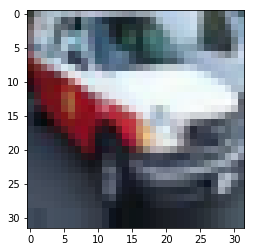

a u t o m o b i l e


In [37]:
transform_cifar10_train = transforms.Compose(
    [transforms.Resize(220),
     #torchvision.transforms.RandomChoice([torchvision.transforms.RandomRotation(10), torchvision.transforms.RandomCrop((32,32), padding=4, padding_mode = 'edge')]),
     transforms.RandomCrop(200),
     #torchvision.transforms.RandomCrop((32,32), padding=5, padding_mode = 'edge'),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))]) 

transform_cifar10_test = transforms.Compose(
    [transforms.Resize(220), 
     transforms.CenterCrop(200),
     transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))]) 


cifar10_train_dset = torchvision.datasets.CIFAR10('./cifar10_pytorch', train=True, transform=transform_cifar10_train, download=False)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_dset, batch_size=500, shuffle=False, num_workers=0)

cifar10_test_dset = torchvision.datasets.CIFAR10('./cifar10_pytorch', train=False, transform=transform_cifar10_test, download=False)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dset, batch_size=500, shuffle=False, num_workers=0)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar10_train_loader)
images, labels = dataiter.next()
rnd_idx = 60 #np.random.randint(100)

# show images
imshow(torchvision.utils.make_grid(images[rnd_idx], nrow=8))
# print labels
print(' '.join('%5s' % classes[labels[rnd_idx]]))



10000


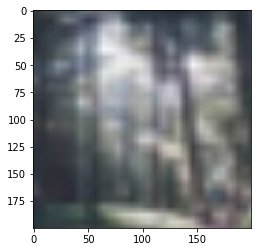

forest


In [65]:
transform_cifar100_train = transforms.Compose(
    [transforms.Resize(220),
     #torchvision.transforms.RandomChoice([torchvision.transforms.RandomRotation(10), torchvision.transforms.RandomCrop((32,32), padding=4, padding_mode = 'edge')]),
     transforms.RandomCrop(200),
     #torchvision.transforms.RandomCrop((32,32), padding=5, padding_mode = 'edge'),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))]) 

transform_cifar100_test = transforms.Compose(
    [transforms.Resize(220), 
     transforms.CenterCrop(200),
     transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))]) 


cifar100_train_dset = torchvision.datasets.CIFAR100('./cifar100_pytorch', train=True, transform=transform_cifar100_train, download=False)
cifar100_train_loader = torch.utils.data.DataLoader(cifar100_train_dset, batch_size=500, shuffle=False, num_workers=0)

cifar100_test_dset = torchvision.datasets.CIFAR100('./cifar100_pytorch', train=False, transform=transform_cifar100_test, download=False)
cifar100_test_loader = torch.utils.data.DataLoader(cifar100_test_dset, batch_size=500, shuffle=False, num_workers=0)

pickleFile = open("./cifar100_pytorch/cifar-100-python/meta", 'rb')
dic = pickle.load(pickleFile)
pickleFile.close()

classes = dic['fine_label_names']

print(len(cifar100_test_dset))

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar100_train_loader)
images, labels = dataiter.next()
rnd_idx = np.random.randint(100)


# show images
imshow(torchvision.utils.make_grid(images[rnd_idx], nrow=8))
# print labels
print(classes[labels[rnd_idx]])


In [46]:
# Extracting features of cifar10 with conv layers of resnet pretrained on imagenet

train_loader = cifar100_train_loader
test_loader = cifar100_test_loader

resnet = models.resnet18(pretrained = True)
resnet_conv = nn.Sequential(*list(resnet.children())[:-1])

for param in resnet_conv.parameters():
    param.requires_grad = False

resnet_conv.cuda()

features_train = []
target_train = []
for i in range(10):
    for idx, (data, target) in enumerate(train_loader):
        data = data.to('cuda')
        target = target.to('cuda')
        features = resnet_conv(data)
#        print(features.shape)
        features = torch.squeeze(features)
        features_train.append(features)
        target_train.append(target)
    

features_dset_train = torch.cat(features_train,0)
target_dset_train = torch.cat(target_train, 0)

features_test = []
target_test = []

for idx, (data, target) in enumerate(test_loader):
    data = data.to('cuda')
    target = target.to('cuda')
    features = resnet_conv(data)
    features = torch.squeeze(features)
    features_test.append(features)
    target_test.append(target)

features_dset_test = torch.cat(features_test,0)
target_dset_test = torch.cat(target_test, 0)

print(features_dset_train.shape, target_dset_train.shape, features_dset_test.shape, target_dset_test.shape)

torch.save(features_dset_train, 'cifar100_features_dataset/train.pt')
torch.save(target_dset_train, 'cifar100_features_dataset/train_targets.pt')
torch.save(features_dset_test, 'cifar100_features_dataset/test.pt')
torch.save(target_dset_test, 'cifar100_features_dataset/test_targets.pt')

torch.Size([500000, 512]) torch.Size([500000]) torch.Size([10000, 512]) torch.Size([10000])
